In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from scipy import stats
from fooof import FOOOFGroup

from galaxybrain.data_utils import load_results, spike_dict, mouse_iter
from galaxybrain.plot_utils import rc_style, pltlabel, plot_all_measures, plot_dist
rc_style()

# This notebook is for investigating the results of analysis 
like correlation of subset size and average spectral exponent

Some common parameters, before I was saving them as json
 - exp5: n_iters = 95; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,1.0]
 
 
### data shapes
```python
pca_m         : (95, 16)
ft_m1         : (95, 16)
ft_m2         : (95, 16)
pearson_p1    : (4, 16)
spearman_p1   : (4, 16)
pearson_p2    : (4, 16)
spearman_p2   : (4, 16)
pca_b         : (95, 16)
ft_b1         : (95, 16)
ft_b2         : (95, 16)
pearson_corr  : (4, 16)
spearman_corr : (4, 16)
eigs          : (16,)
pows          : (16, 61)
pca_er        : (95, 16)
ft_er1        : (95, 16)
ft_er2        : (95, 16)
```
# Loading, plotting results

In [10]:
nosum = load_results('../data/experiments/NOSUM')
mice = load_results('../data/experiments/exp6', kind='mouse_old')

{'n_iters': 95, 'n_pc': 0.8, 'f_range': [0, 0.4]}
{'n_iters': 95, 'n_pc': 0.8, 'f_range': [0, 0.4]}


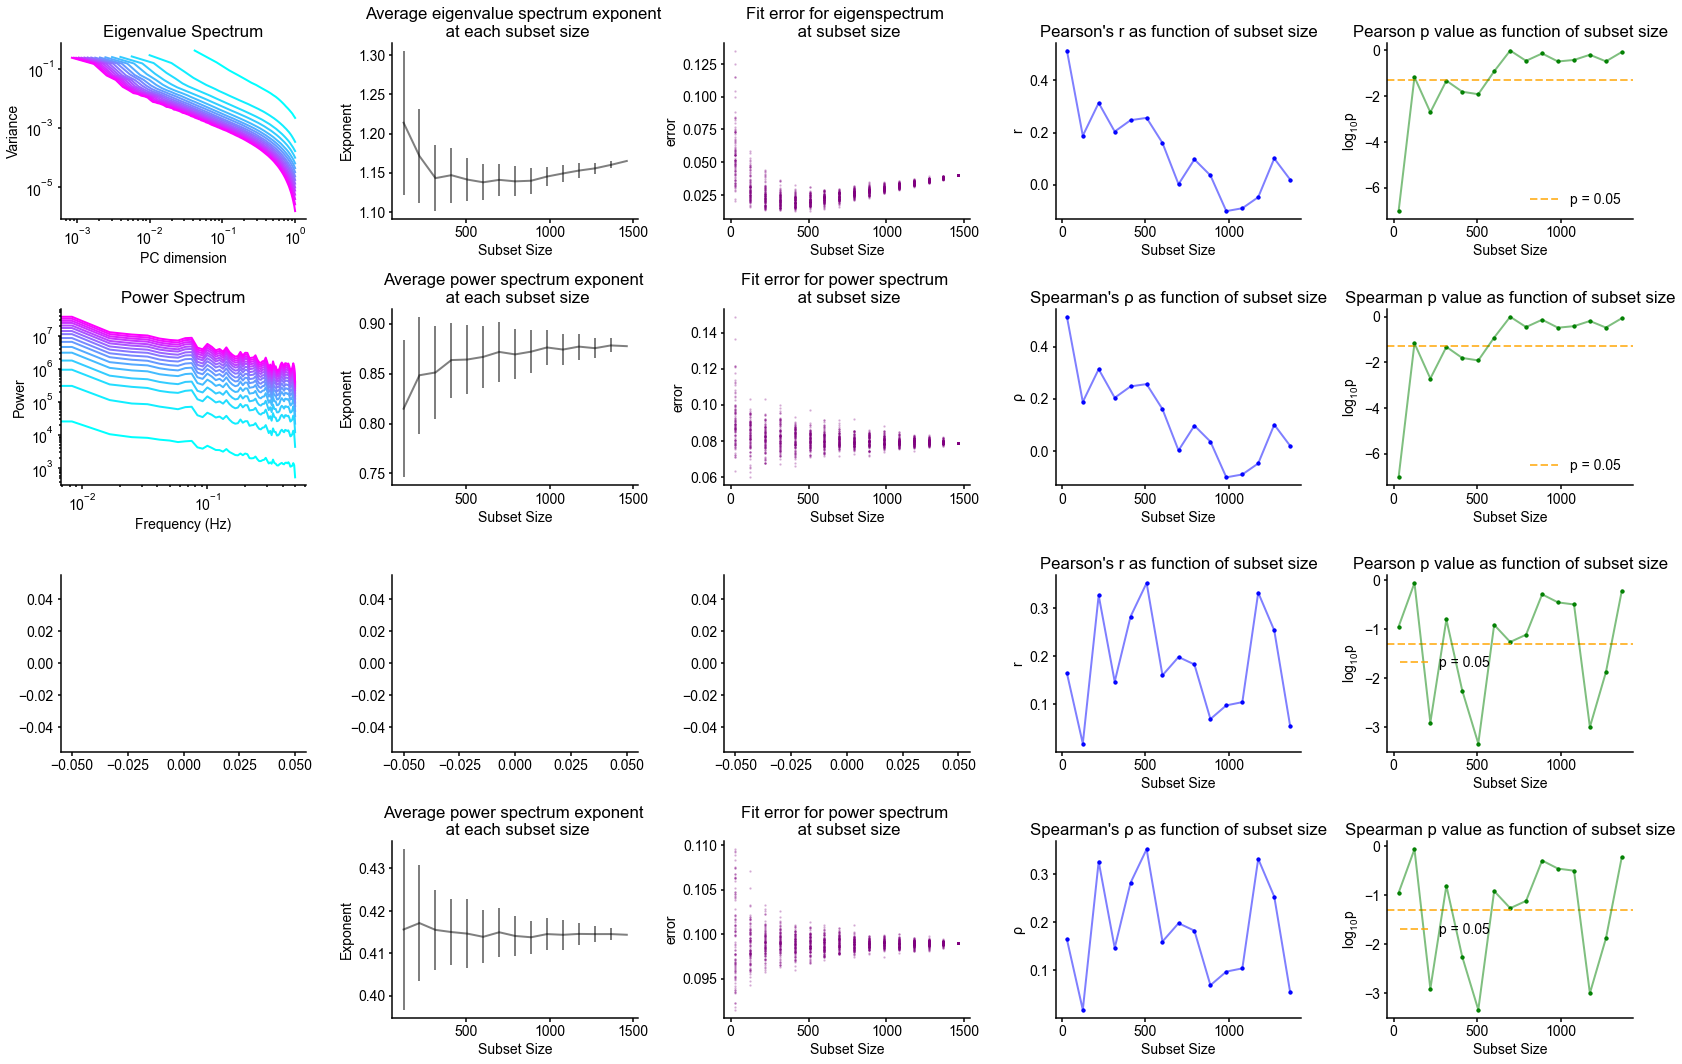

In [142]:
d = nosum
plot_all_measures(d['krebs']['all']['data'], {**d['krebs']['all']['meta'], **d['meta']})

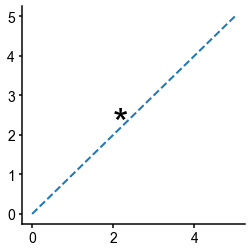

# ^ want to plot example  for single region (spectra)
- one exponent per subset size 
- incluide exponent, and just one correlation with stars @ significance
- error in supp. fig
- consider either/both heatmap and bar plot for summary
- look for any interesting subset sizes, other patterns

# violin plots

comparing distr of exp in summ vs non sum, interestinc omparison (converging vs diverging to mean)

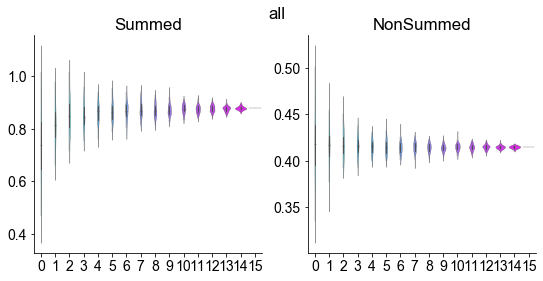

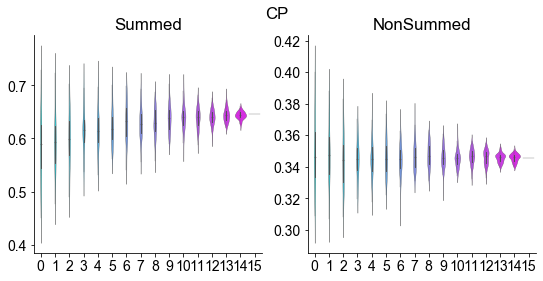

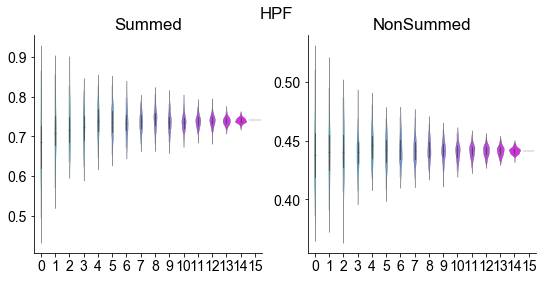

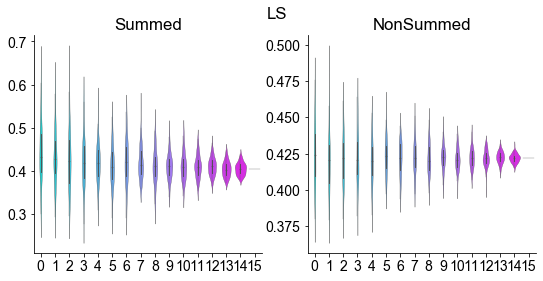

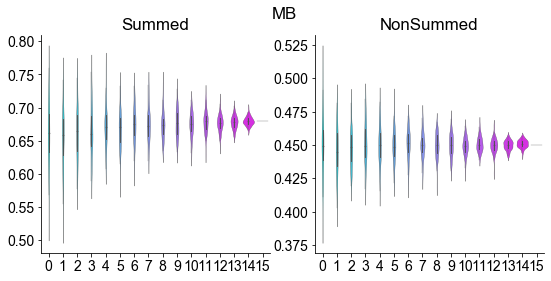

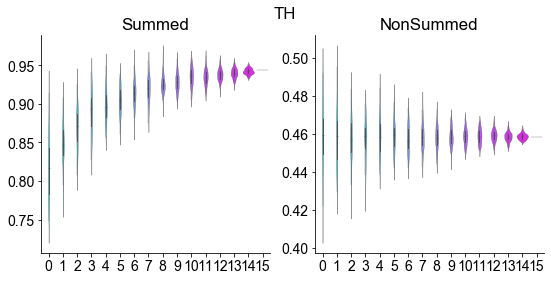

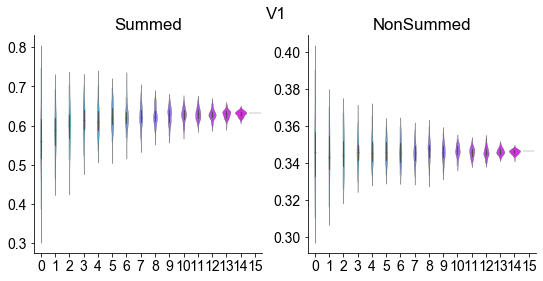

In [ ]:
for rgn in nosum['krebs']:
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plot_dist(rgn, '1', 'Summed')
    plt.subplot(1,2,2)
    plot_dist(rgn, '2', 'NonSummed')
    plt.suptitle(rgn)

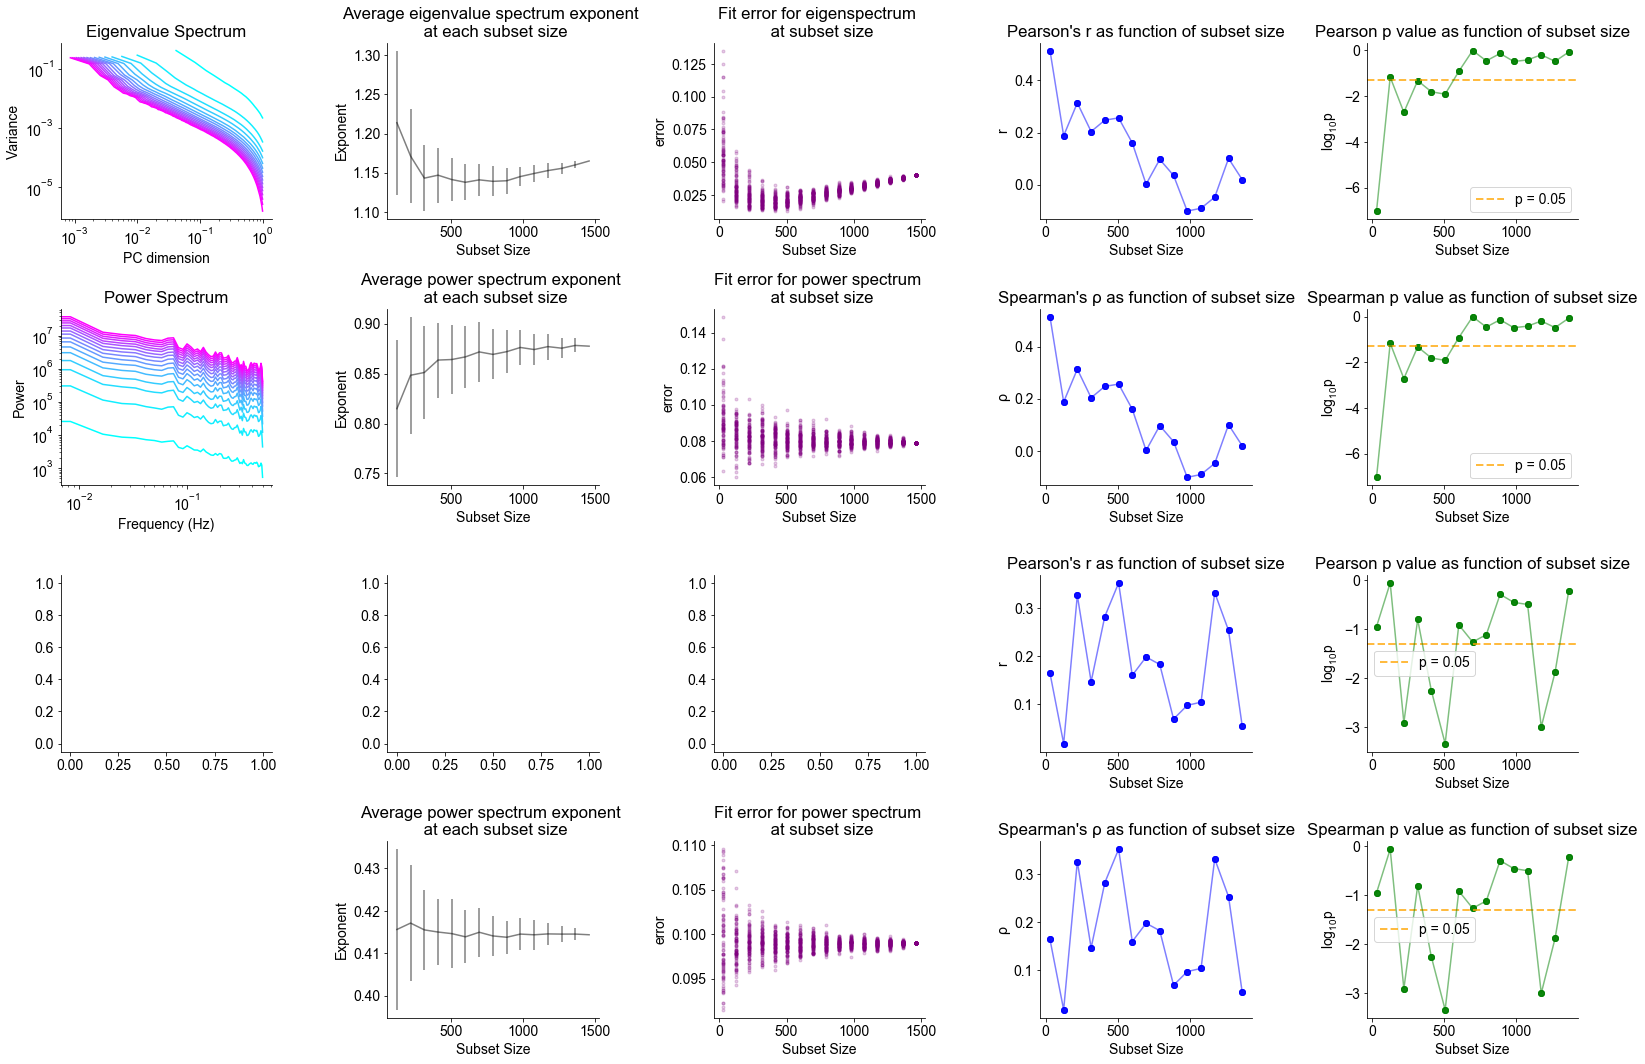

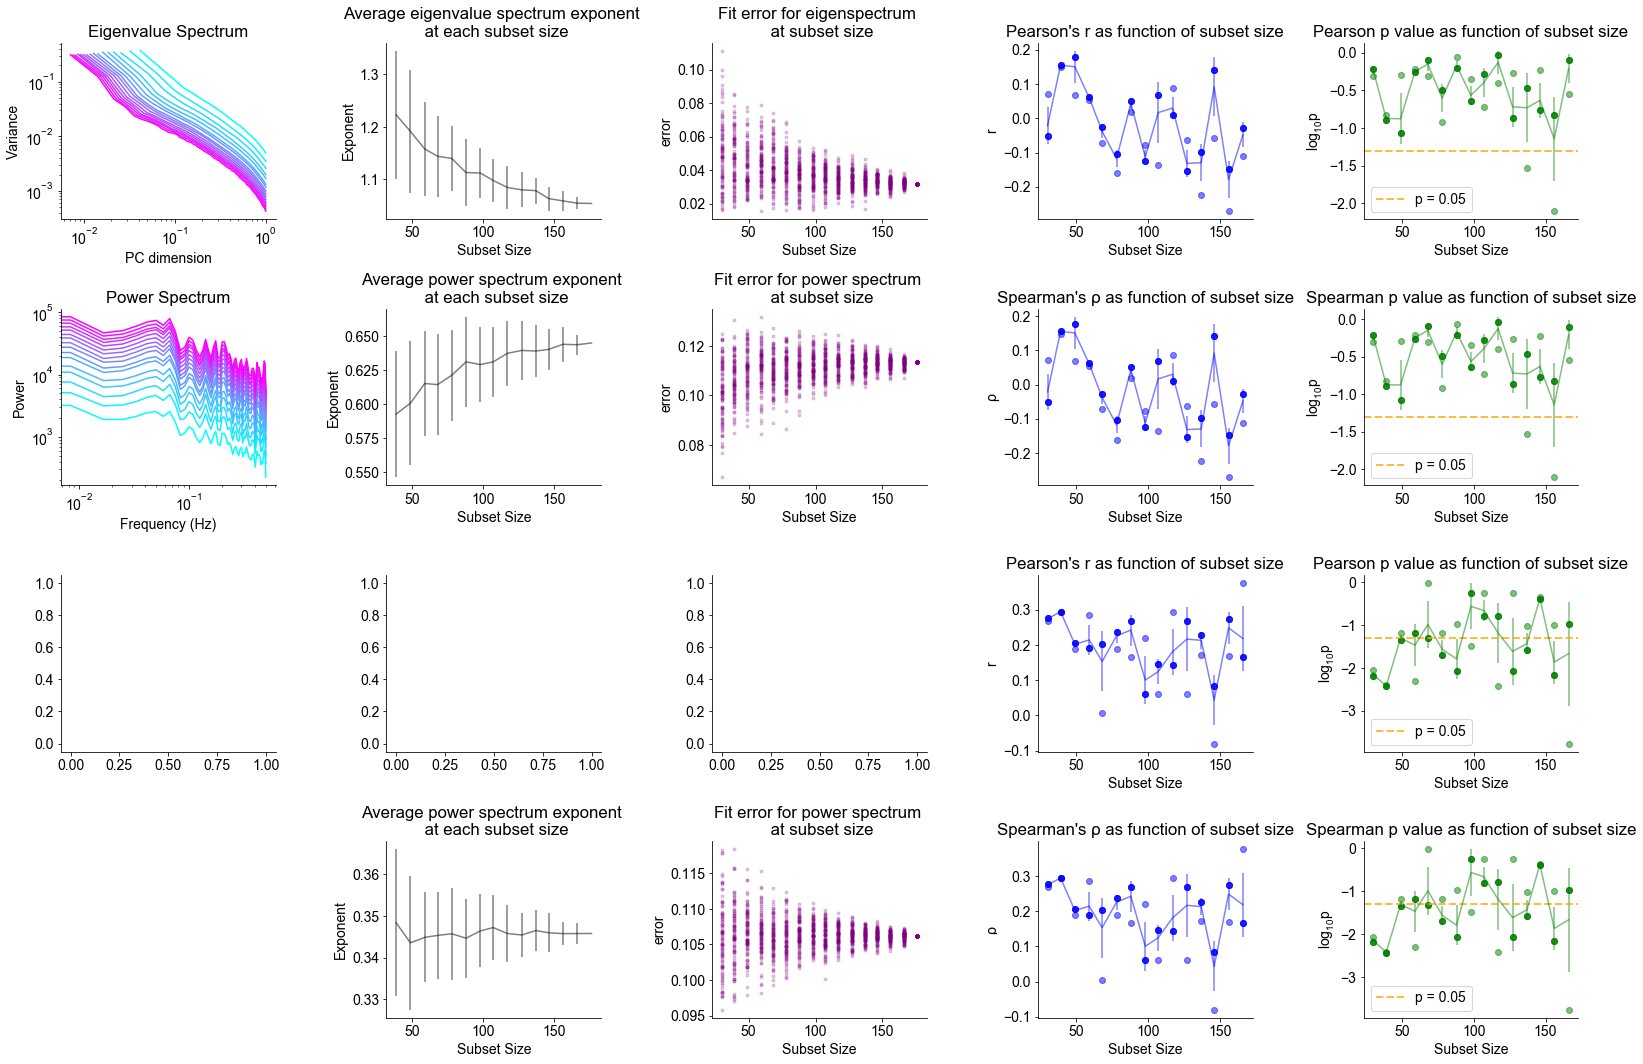

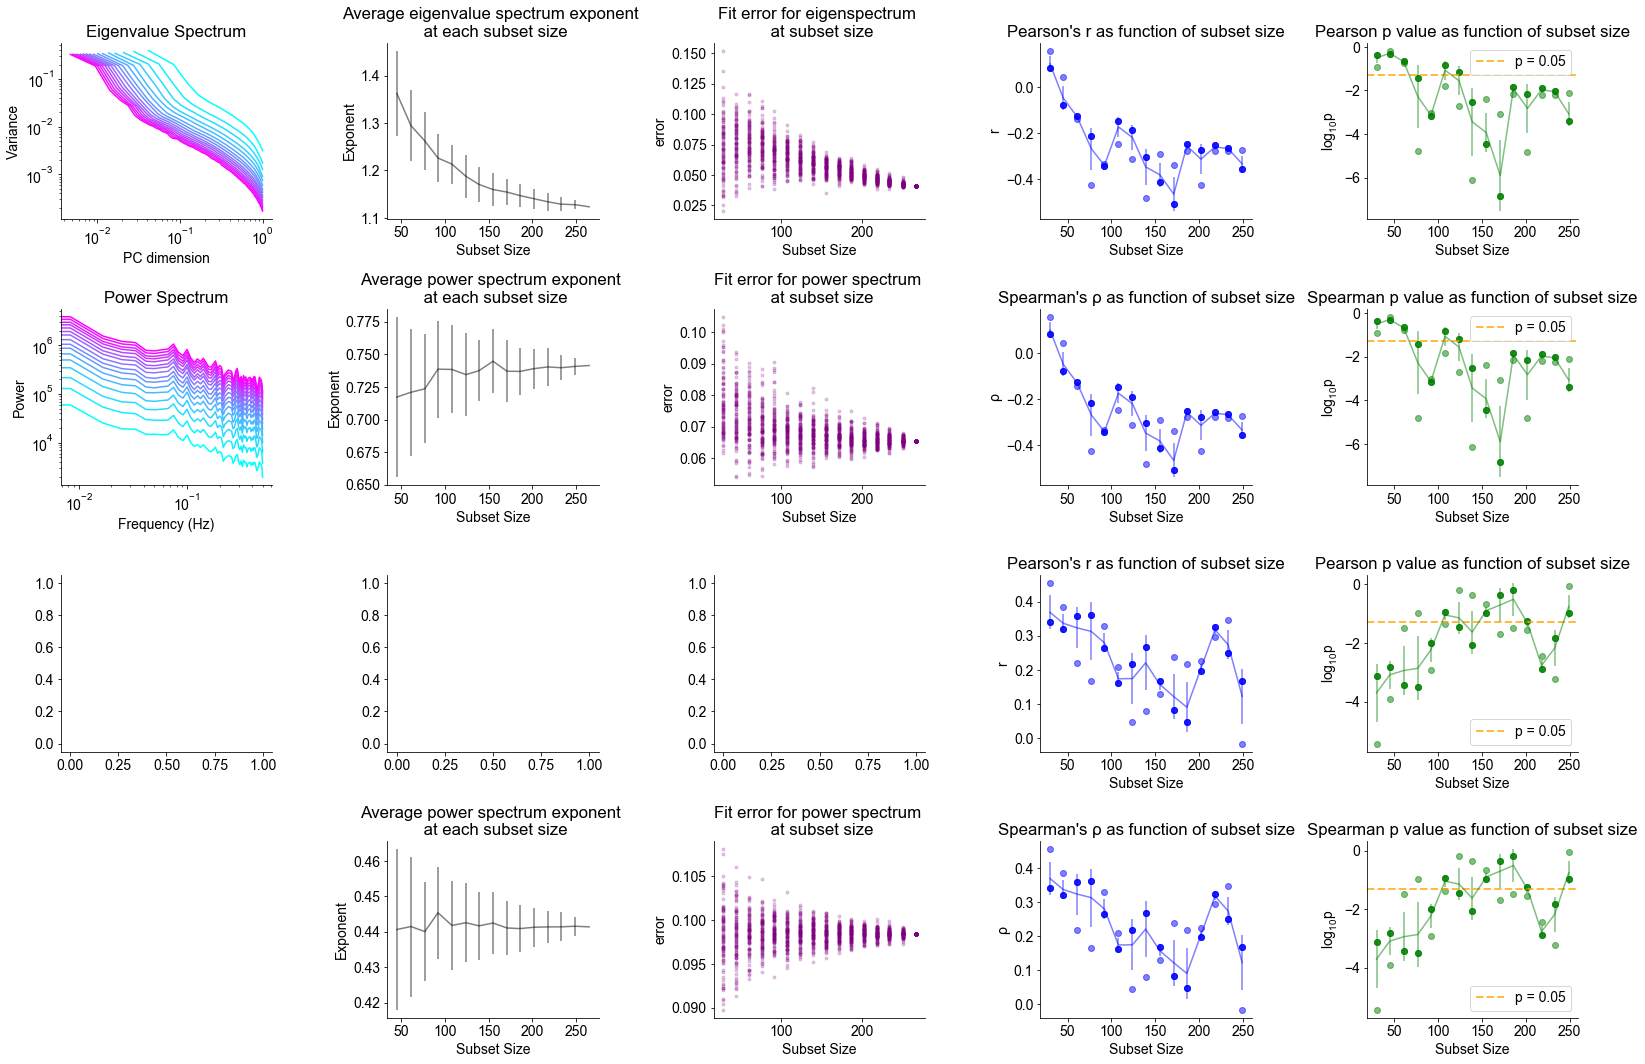

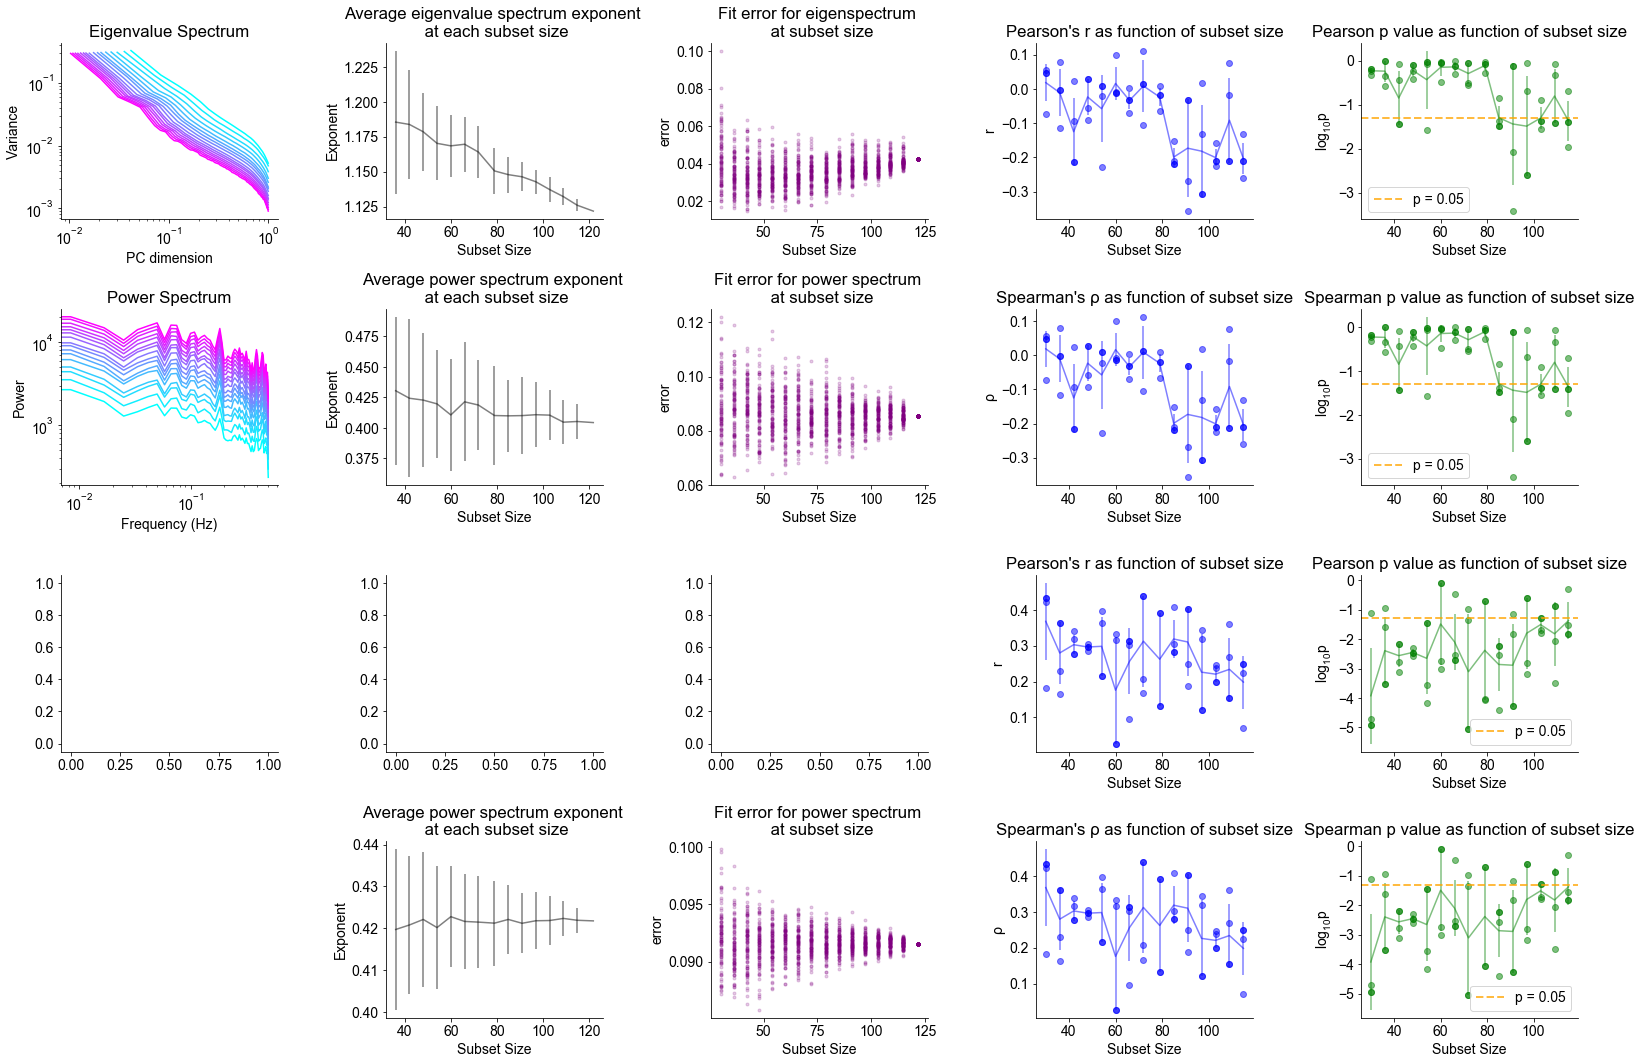

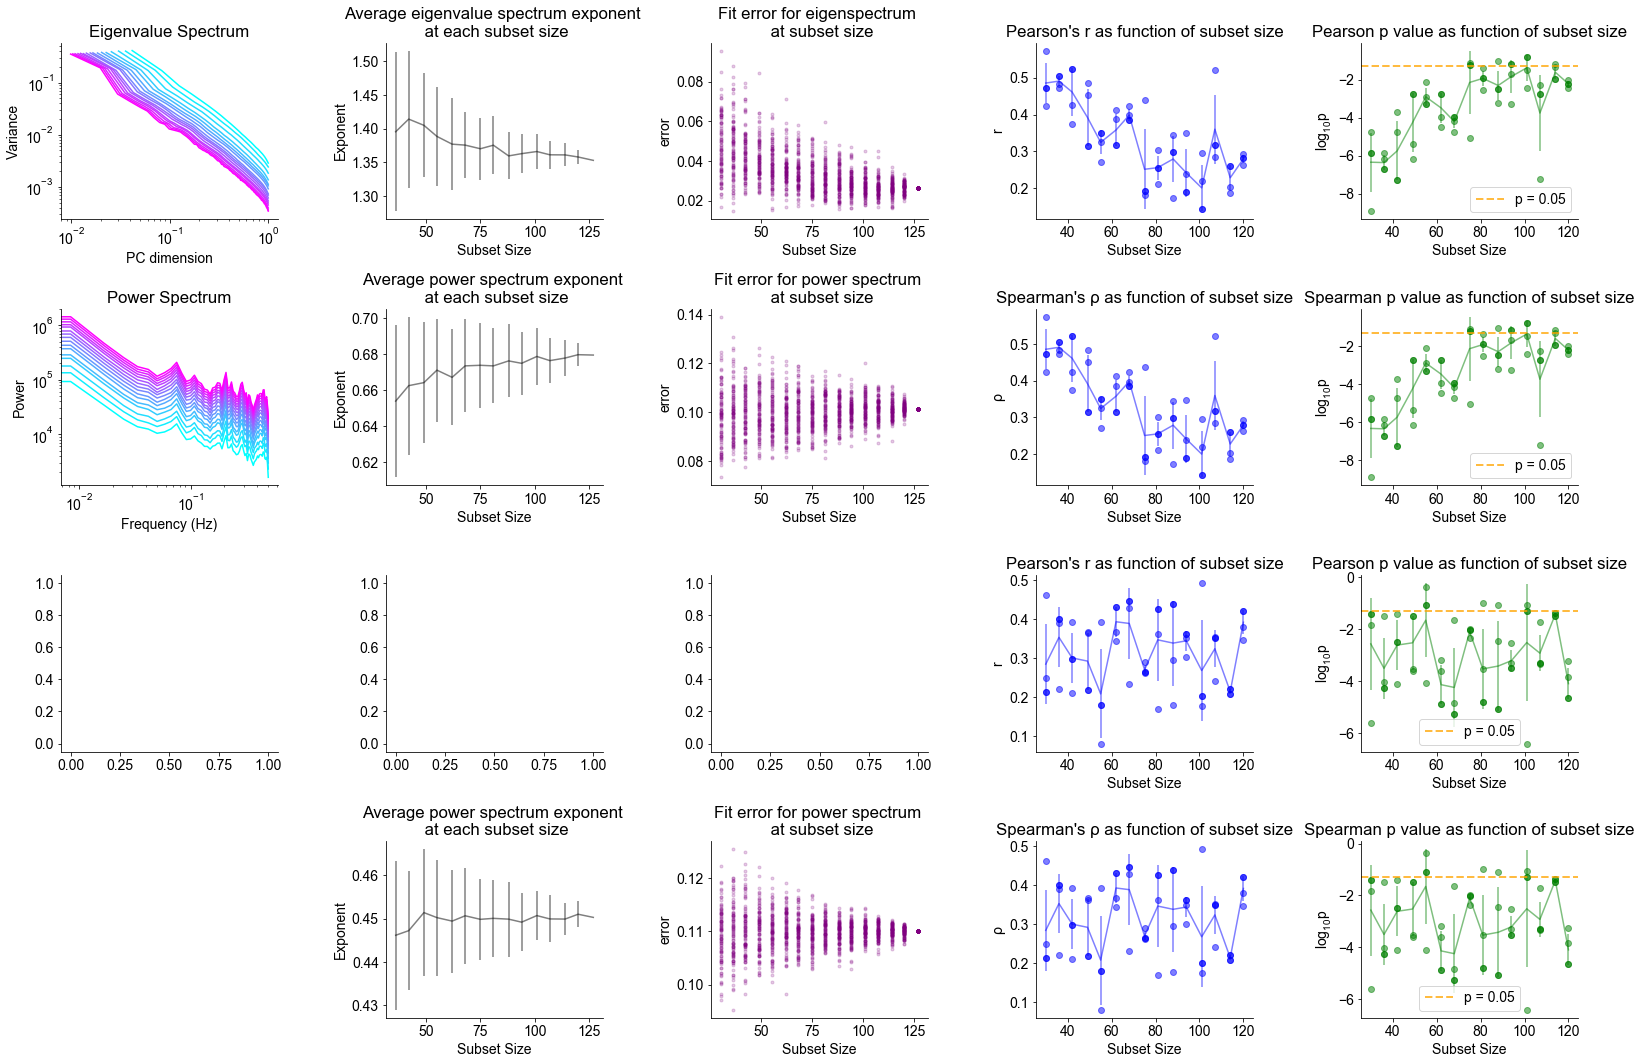

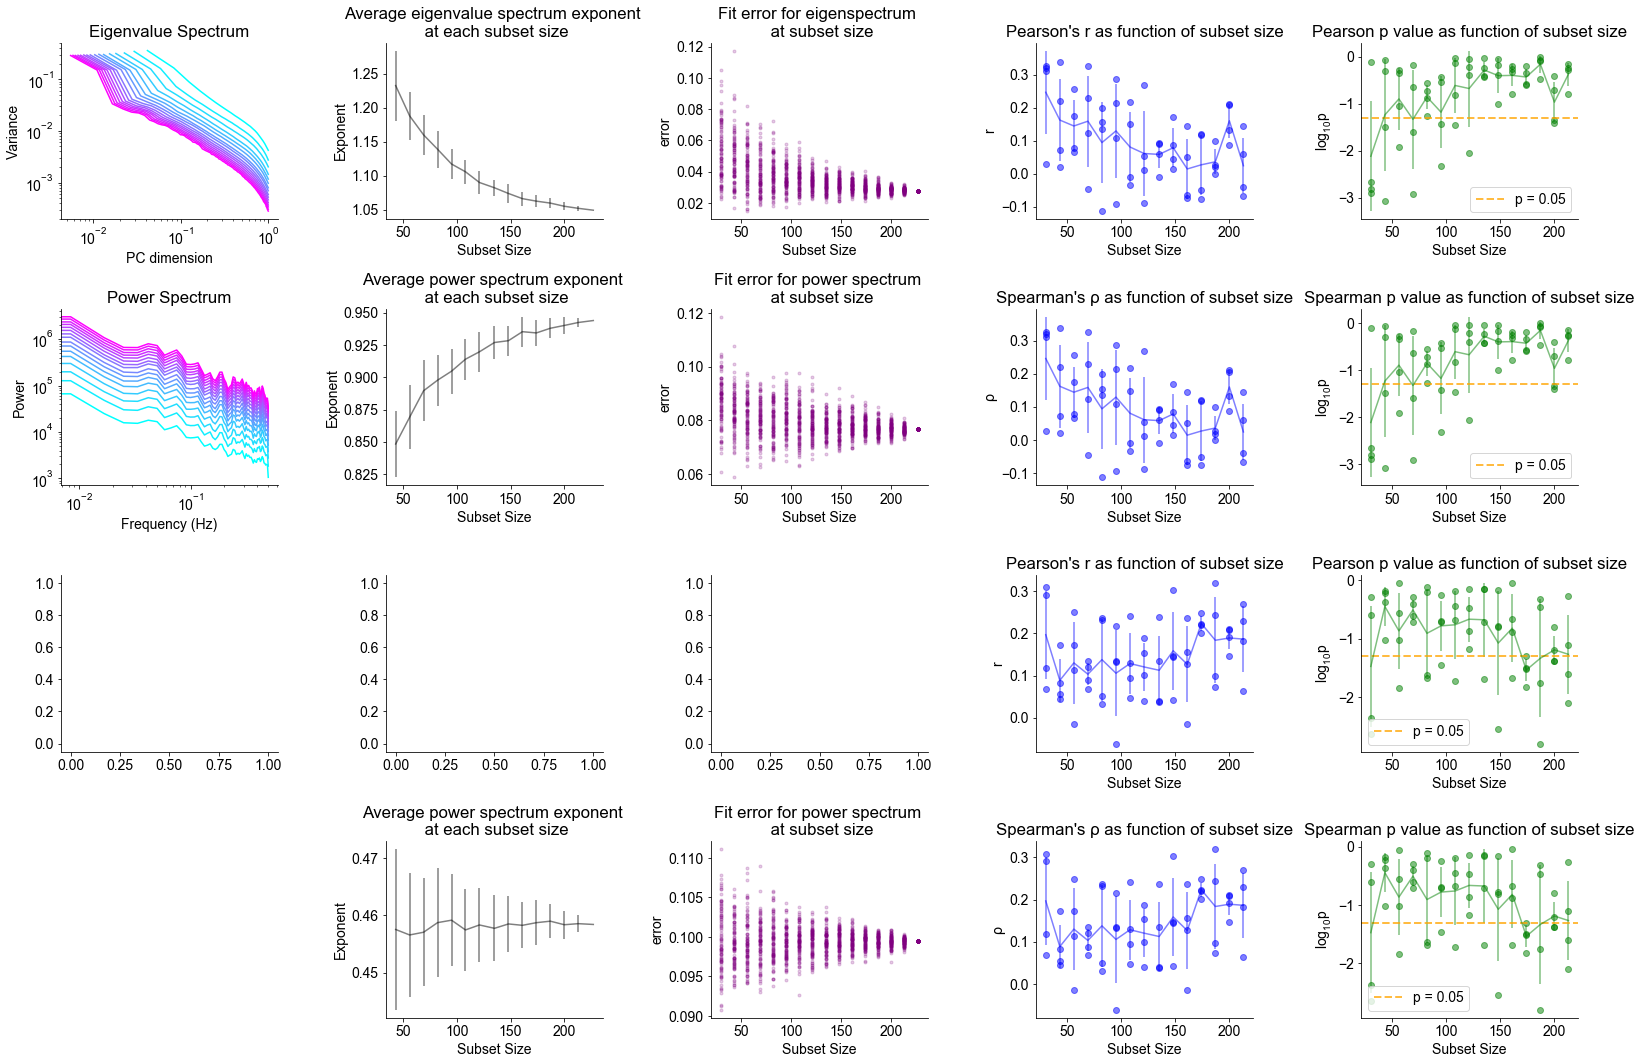

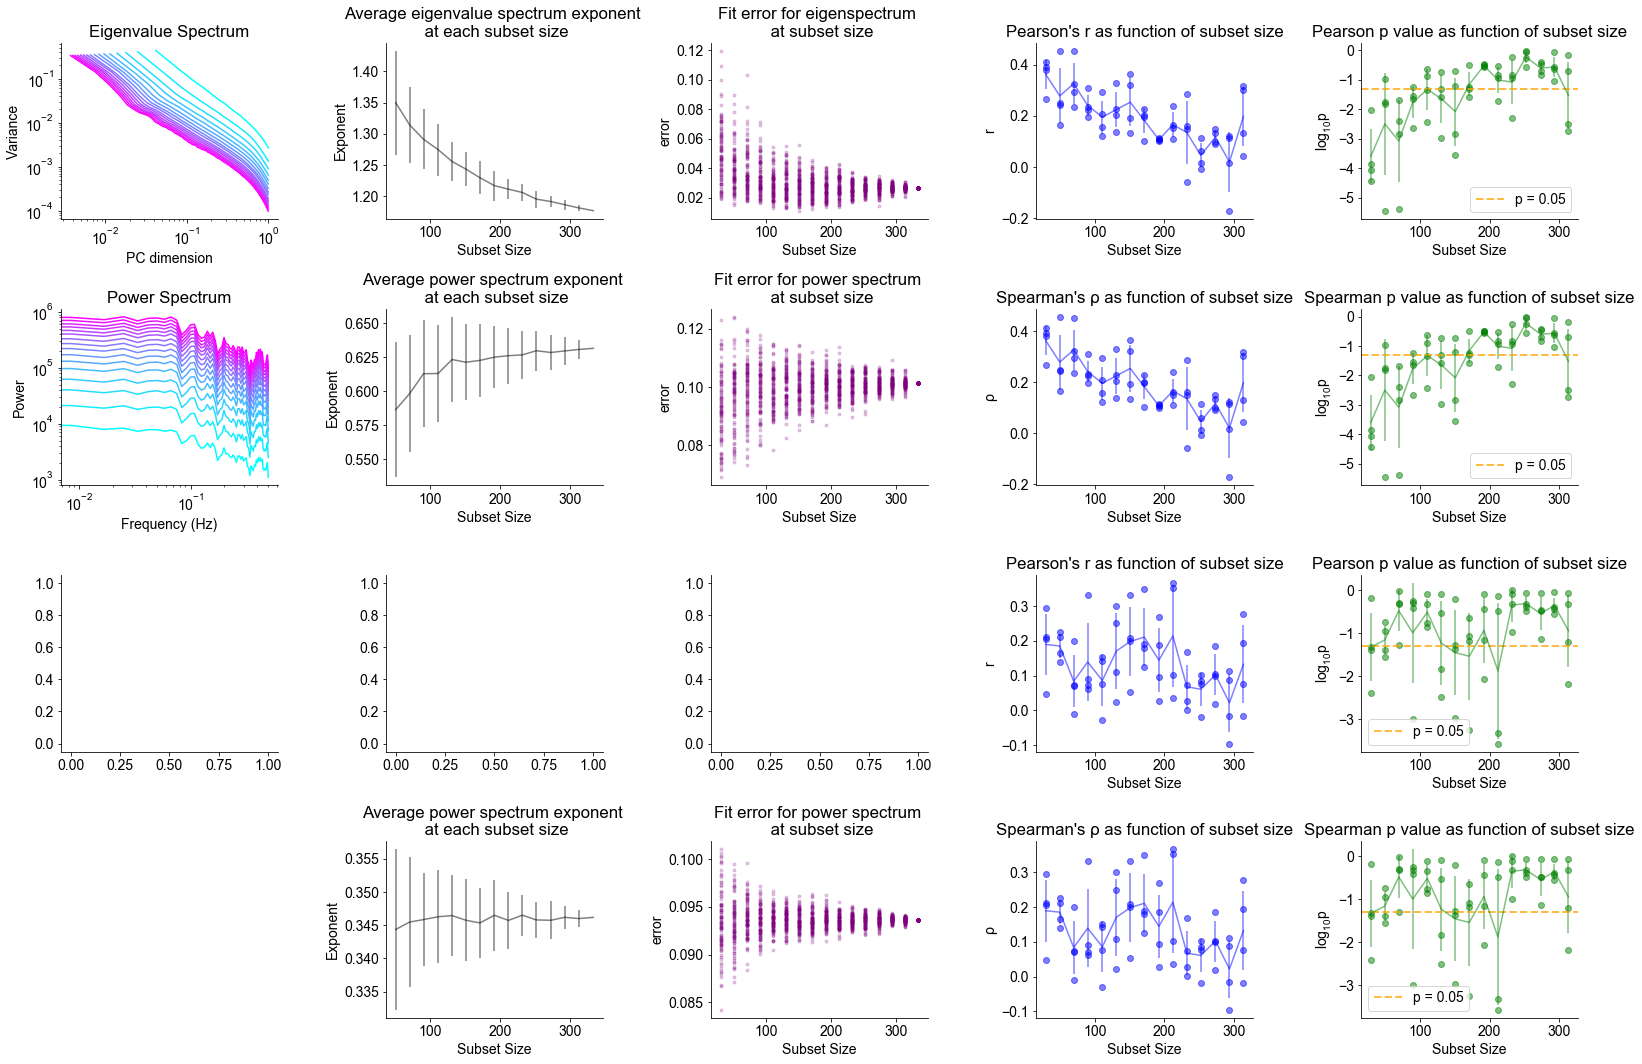

In [44]:
for r in ['all', 'CP', 'HPF', 'LS', 'MB', 'TH', 'V1']:
    plot_all_measures(nosum['krebs'][r]['data'])

../galaxybrain/data_utils.py:224: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  decomp_arr = np.array(decomp_arr)


In [2]:
raster_dict = spike_dict([0])
from galaxybrain.ramsey import ft_on_data
mouse_key = 'krebs'
n_iter = 30
burn_in = 20 #use for later things 
ft_kwargs = {'fs':1, 'nperseg':120, 'noverlap':60}
ft_data = {}
freqs = np.fft.rfftfreq(ft_kwargs['nperseg'])

Mouse 1
Grabbing Spikes...
Binning Spikes...
[('CP', 176), ('FrMoCtx', 78), ('HPF', 265), ('LS', 122), ('MB', 127), ('SC', 42), ('SomMoCtx', 91), ('TH', 227), ('V1', 334)] Total: 1462


In [25]:
from neurodsp.spectral import compute_spectrum

mouse_data = mouse_iter(raster_dict, mouse_key, burn_in)
fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed', verbose = False)

### CONVERT TO FIRING RATE
for mouse_raster, region_name, region_count in mouse_data:
    total_spikes = mouse_raster.sum(0)
    fr = total_spikes/len(mouse_raster)
    freqs, powers_chans = compute_spectrum(mouse_raster.T, **ft_kwargs)
    fg.fit(freqs, powers_chans) 
    exponents = fg.get_params('aperiodic_params', 'exponent')
    offsets = fg.get_params('aperiodic_params', 'offset')
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.scatter(fr, exponents, color='indianred', s=3);     plt.xscale('log')
    plt.xlabel('log(spike count)');    plt.ylabel('exponent')
    rho, p = stats.spearmanr(total_spikes, exponents)
    plt.title(f'region: {region_name}, ρ: {rho:.2f}, p: {p:.2f}')

    plt.subplot(1,3,2)
    plt.scatter(fr, offsets, color='turquoise', s=3);     plt.xscale('log')
    plt.xlabel('log(spike count)');    plt.ylabel('offset')
    rho, p = stats.spearmanr(total_spikes, offsets)
    plt.title(f'ρ: {rho:.2f}, p: {p:.2f}')
    
    plt.subplot(1,3,3)
    plt.scatter(offsets, exponents, color='orange', s=3);     #plt.xscale('log')
    plt.xlabel('offsets');    plt.ylabel('exponent')
    rho, p = stats.spearmanr(offsets, exponents)
    plt.title(f'ρ: {rho:.2f}, p: {p:.2f}')

NameError: name 'raster_dict' is not defined

### Just taking PSD for non summed data since this is not done in the pipeline

In [38]:


mouse_data = mouse_iter(raster_dict, mouse_key, burn_in)
for mouse_raster, region_name, region_count in mouse_data:
    subsetsizes = np.linspace(30,region_count,16, dtype=int)
    
    ### DATA
    ft_data[region_name] = []
    for subset_size in subsetsizes:
        loc_array = np.sort(np.random.choice(mouse_raster.shape[1], subset_size, replace=False))
        subset = np.array(mouse_raster.iloc[:,loc_array]) #currently converted to array for test
        chan_powers_mat = np.zeros((n_iter, subset_size, len(freqs)))

        for i in range(n_iter):
            freqs, powers_sum, powers_chans = ft_on_data(subset, **ft_kwargs)

            chan_powers_mat[i] = powers_chans
            
        ft_data[region_name].append(chan_powers_mat.mean(0).mean(0))

all
CP
HPF
LS
MB
TH
V1


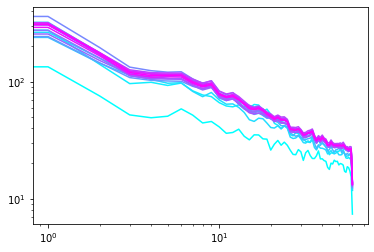

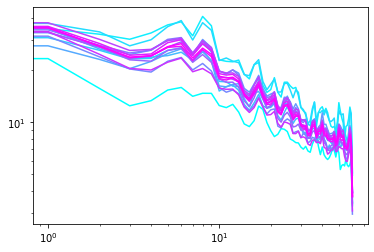

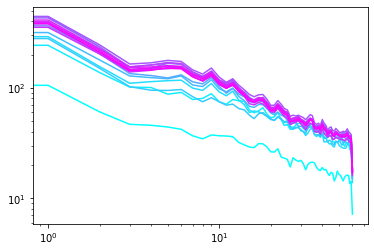

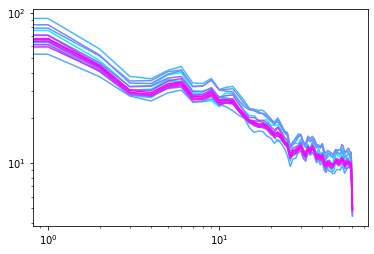

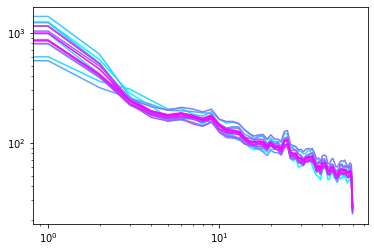

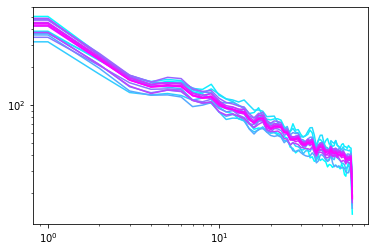

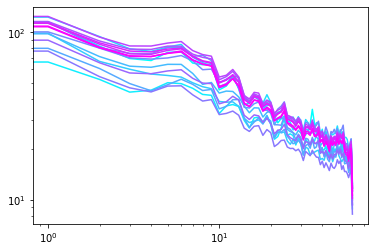

In [42]:
colors = list(iter(plt.cm.cool(np.linspace(0, 1, 16))))
for k,v in ft_data.items():
    plt.figure()
    for i, p in enumerate(v):
        plt.loglog(p,color=colors[i])

In [92]:
#np.array([decomp_arr[i][4] for i in range(4)], dtype=float)
np.array([pearson_r[i] for i in range(4)], dtype=float)

array([[ 0.23237682,  0.21879899,  0.08713606,  0.18678611,  0.30246361,
         0.15464726,  0.28440649,  0.17529395,  0.00908455,  0.0193869 ,
         0.02852744,  0.1825308 ,  0.30326148,  0.12628779, -0.06080627,
                nan],
       [ 0.12460806,  0.23283875,  0.31714726,  0.31461366,  0.16819709,
         0.14347704,  0.25068589,  0.18255879,  0.16794513,  0.29400896,
         0.27297032,  0.12393617,  0.03510638, -0.1225084 ,  0.19892217,
                nan],
       [ 0.24349104,  0.19839026,  0.14736842,  0.11620941,  0.26910694,
         0.17635778,  0.09767637,  0.27411814,  0.05596305,  0.31871501,
         0.13366461,  0.11891097,  0.18394457, -0.02919933, -0.09847424,
                nan],
       [ 0.07066069,  0.27413214,  0.2925252 ,  0.28159295,  0.2049972 ,
         0.05942049,  0.14098544,  0.23954367,  0.21522956,  0.24101344,
         0.22434211,  0.18202688,  0.17368421,  0.06804311,  0.15708287,
                nan]])

## Correlating subset size and spectral exponent

Calculate r (pearson, spearman) for each (mouse, region) and average (since for each datum shape is 2d, (95,16)) <br>
Keep in mind each set of exponents is averaged across 4 trials (due to `decomp_arr[:,0 or 1].mean(0)`)

In [3]:
mouse_means_eigx = {'pearson': ([],[]), 'spearman': ([],[])} # see below
mouse_means_psdx = {'pearson': ([],[]), 'spearman': ([],[])} # stat means ([r], [p]) for each region in each mouse, to be averaged again later 
for mouse_key in ['krebs', 'robbins', 'waksman']:
    for region in data_dict[mouse_key]:
        region_name, region_count, data = region[0], region[1], region[2]
        e_exp, p_exp = data['espec_exp'], data['psd_exp']
        subsetsizes = data['subsetsizes']
        espec_corr_array_curr = {'pearson': ([],[]), 'spearman': ([],[])}
        psd_corr_array_curr = {'pearson': ([],[]), 'spearman': ([],[])} # each correlation's array will have a correlation array and a p-value array
        for i in e_exp:
            espec_corr_array_curr['pearson'][0].append(stats.pearsonr(subsetsizes, i)[0])
            espec_corr_array_curr['pearson'][1].append(stats.pearsonr(subsetsizes, i)[1])
            
            espec_corr_array_curr['spearman'][0].append(stats.spearmanr(subsetsizes, i)[0])
            espec_corr_array_curr['spearman'][1].append(stats.spearmanr(subsetsizes, i)[1])
            
        for i in p_exp:
            psd_corr_array_curr['pearson'][0].append(stats.pearsonr(subsetsizes, i)[0])
            psd_corr_array_curr['pearson'][1].append(stats.pearsonr(subsetsizes, i)[1])
            
            psd_corr_array_curr['spearman'][0].append(stats.spearmanr(subsetsizes, i)[0])
            psd_corr_array_curr['spearman'][1].append(stats.spearmanr(subsetsizes, i)[1])
        
        region[2]['subset-exp correlation'] = {'espec': espec_corr_array_curr, 'psd': psd_corr_array_curr}
        
        #appending data for print statment below. Wow this is messy
        mouse_means_eigx['pearson'][0].append(np.mean(espec_corr_array_curr['pearson'][0])); mouse_means_eigx['spearman'][0].append(np.mean(espec_corr_array_curr['spearman'][0]));
        mouse_means_eigx['pearson'][1].append(np.mean(espec_corr_array_curr['pearson'][1])); mouse_means_eigx['spearman'][1].append(np.mean(espec_corr_array_curr['spearman'][1])) 
        
        mouse_means_psdx['pearson'][0].append(np.mean(psd_corr_array_curr['pearson'][0])); mouse_means_psdx['spearman'][0].append(np.mean(psd_corr_array_curr['spearman'][0])) 
        mouse_means_psdx['pearson'][1].append(np.mean(psd_corr_array_curr['pearson'][1])); mouse_means_psdx['spearman'][1].append(np.mean(psd_corr_array_curr['spearman'][1])) 

e_p_m, e_p_p = np.mean(mouse_means_eigx['pearson'][0]), np.mean(mouse_means_eigx['pearson'][1]); e_s_m, e_s_p = np.mean(mouse_means_eigx['spearman'][0]), np.mean(mouse_means_eigx['spearman'][1])
p_p_m, p_p_p = np.mean(mouse_means_psdx['pearson'][0]), np.mean(mouse_means_psdx['pearson'][1]); p_s_m, p_s_p = np.mean(mouse_means_psdx['spearman'][0]), np.mean(mouse_means_psdx['spearman'][1]) 
print('Eigenspectrum: avg subset-exp correlation pearson r:{:.4f}, p:{:.4f}, spearman r:{:.4f}, p:{:.4f}'.format(e_p_m, e_p_p, e_s_m, e_s_p))
print('PSD: avg subset-exp correlation pearson r:{:.4f}, p:{:.4f}, spearman r:{:.4f}, p:{:.4f}'.format(p_p_m, p_p_p, p_s_m, p_s_p))

Eigenspectrum: avg subset-exp correlation pearson r:-0.6349, p:0.0359, spearman r:-0.6553, p:0.0640
PSD: avg subset-exp correlation pearson r:0.4077, p:0.1540, spearman r:0.4169, p:0.1823


# Power law fit

goodness of power law fit increases, variability of goodness of fit decreases <br>
VIZ: same idea: also look at avg r2, std dev

In [36]:
r2_metadata = {'eig':([],[]),'psd':([],[])}
for mouse_key in ['krebs', 'robbins', 'waksman']:
    for region in data_dict[mouse_key]:
        data = region[2]
        subsetsizes = data['subsetsizes']
        e_r2, p_r2 = data['space_r2'], data['time_r2'] #goodness of fits
        r2_metadata['eig'][0].append(e_r2.mean(0))
        r2_metadata['eig'][1].append(e_r2.std(0))
        
        r2_metadata['psd'][0].append(p_r2.mean(0))
        r2_metadata['psd'][1].append(p_r2.std(0))

Text(0.5, 0.04, '% neurons')

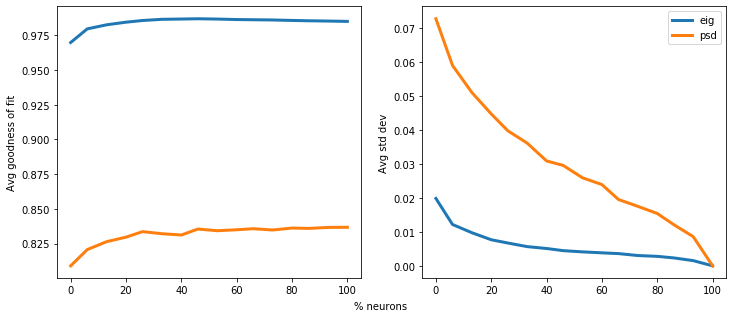

In [52]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,100,16, dtype=int), np.array(r2_metadata['eig'][0]).mean(0), linewidth = 3)
plt.plot(np.linspace(0,100,16, dtype=int), np.array(r2_metadata['psd'][0]).mean(0), linewidth = 3)
plt.ylabel('Avg goodness of fit')

plt.subplot(1,2,2)
plt.plot(np.linspace(0,100,16, dtype=int), np.array(r2_metadata['eig'][1]).mean(0), linewidth = 3)
plt.plot(np.linspace(0,100,16, dtype=int), np.array(r2_metadata['psd'][1]).mean(0), linewidth = 3)
plt.ylabel('Avg std dev')
plt.legend(labels = ['eig','psd'])
fig.text(0.5, 0.04, '% neurons', ha='center')